# Figures for NetCIS publication

In [163]:
import ast
from pathlib import Path

import pandas as pd
import numpy as np
import seaborn as sns
import seaborn.objects as so
from seaborn import axes_style
from IPython.display import display
import statsmodels.api as sm
import matplotlib.pyplot as plt
import scipy.stats as stats

def volcano_plot(df, lfc, pval, threshold=0.05):
    """
    Create a volcano plot to visualize p-value and log fold change.

    Args:
        data (pandas.DataFrame): Data for the plot
        lfc (str): Column name for log fold change values
        pval (str): Column name for p-values
        threshold (float, optional): Significance threshold for p-values. Default is 0.05.

    Returns:
        seaborn.axisgrid.FacetGrid: Volcano plot visualization
    """
    data = df.copy(deep=True)
    thres = np.log10(threshold) * -1
    data[pval] = np.log10(data[pval]) * -1
    g = (
        so.Plot(data, x=lfc, y=pval, pointsize=pval)
        # .add(so.Dots(), so.Jitter(1))
        .add(so.Dots(color="grey"), data=data.query(f"{pval} < {thres}"))
        .add(so.Dots(color="blue"), data=data.query(f"{pval} >= {thres}"))
        .scale(y="log")
    )
    return g

def gene_search(df, gene_search):
    """search for a gene in the pCIS or CIS dataframe

    Args:
        df (pandas.DataFrame): dataframe of either pCIS or CIS
        gene_search (str): gene name, such as "Aak1"

    Returns:
        pandas.DataFrame: subset of df that were associated with the gene of interest
    """
    return df[df["genes"] == gene_search]

def remove_Gm(gene_list):
    """_summary_

    Args:
        gene_list (_type_): _description_

    Returns:
        _type_: _description_
    """
    genes_out = []
    if type(gene_list) is not list:
        gene_list = ast.literal_eval(gene_list)
    for gene in gene_list:
        if not gene.startswith("Gm"):
            genes_out.append(gene)
    return genes_out

def ranked_pCIS(df):
    """_summary_

    Args:
        df (_type_): _description_

    Returns:
        _type_: _description_
    """
    df["ranksums_ranked"] = df["ranksums"].rank()
    df["fishers_exact_ranked"] = df["fishers_exact"].rank()
    df["total_num_samples_ranked"] = df["total_num_samples"].rank(ascending=False)
    df["overall_rank"] = (df["ranksums_ranked"] + df["fishers_exact_ranked"] + df["total_num_samples_ranked"]).rank()
    return df.sort_values("overall_rank")

def quantile_selection(df, column, quant):
    """_summary_

    Args:
        df (_type_): _description_
        column (_type_): _description_
        quant (_type_): _description_

    Returns:
        _type_: _description_
    """
    quant_rank = df[column].quantile(quant)
    return df[df[column] < quant_rank].sort_values(column)

def candidate_genes(df):
    """_summary_

    Args:
        df (_type_): _description_

    Returns:
        _type_: _description_
    """
    df["CIS_start"] = df[["case_pos_min", "case_pos_max", "control_pos_min", "control_pos_max"]].min(axis=1)
    df["CIS_end"] = df[["case_pos_min", "case_pos_max", "control_pos_min", "control_pos_max"]].max(axis=1)
    cols = ["overall_rank", "chrom", "CIS_start", "CIS_end", "genes", "ranksums", \
        "fishers_exact", "total_num_samples", "case_num_samples", "control_num_samples", "case", "control"]
    df["genes"] = df["genes"].apply(lambda x: remove_Gm(x))
    return df[cols].explode("genes").reset_index(drop=True)


In [164]:
output_2020_LT = Path("/home/fisch872/mat/projects/Laura-SB-Analysis/2020_SB-output/GRCm39/results-analysis/LT-S")
output_2020_RT = Path("/home/fisch872/mat/projects/Laura-SB-Analysis/2020_SB-output/GRCm39/results-analysis/RT-S")
output_ACF = Path("/home/fisch872/mat/projects/Laura-SB-Analysis/2023-SB-screen/output/ACF_SCF/GRCm39/results-analysis/ACF-SCF")
output_CAR = Path("/home/fisch872/mat/projects/Laura-SB-Analysis/2023-SB-screen/output/CAR_NoCAR/GRCm39/results-analysis/CAR-NoCAR")

In [165]:
output = output_2020_LT

IS_df = pd.read_csv(output / "IS.tsv", sep="\t")
pCIS_df = pd.read_csv(output / "pCIS.tsv", sep="\t")

count    11230.000000
mean      5615.500000
std       3224.379238
min          1.000000
25%       2817.500000
50%       5711.500000
75%       8549.000000
max       9999.000000
Name: overall_rank, dtype: float64

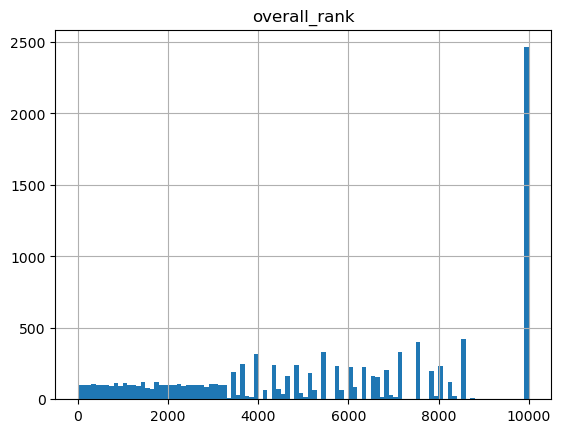

In [166]:
ranked_pCIS_df = ranked_pCIS(pCIS_df)
ranked_pCIS_df.hist(column="overall_rank", bins=100)
ranked_pCIS_df["overall_rank"].describe()

In [170]:
# select pCIS to CIS based on either a quantile selection or a minumum number of total samples in the pCIS
# or both???

# CIS_df = quantile_selection(ranked_pCIS_df, "overall_rank", 0.1)
CIS_df = ranked_pCIS_df[ranked_pCIS_df["total_num_samples"] >= 10].copy(deep=True)
CIS_df

,case_index,case_pos_min,case_pos_max,control_index,control_pos_min,control_pos_max,LFC,ranksums,binomial,fishers_exact,...,case_total_read_count,control_total_read_count,case,control,chrom,genes,ranksums_ranked,fishers_exact_ranked,total_num_samples_ranked,overall_rank
6957,0,3000004.0,3038212.0,0,3000283.0,3038183.0,1.669447,3.213570e-68,0.000000e+00,0.006994,...,14664.394384,4609.415436,LT,S,chr9,"['Mir101c', 'Gm10719', 'Gm10718', 'Gm10717', '...",1.0,16.0,4.0,1.0
11168,0.0,169134075.0,169134182.0,83.0,169134077.0,169134162.0,4.327447,2.596448e-09,0.000000e+00,0.000149,...,3318.863118,164.359372,LT,S,chr1,[],7.0,2.0,18.0,2.0
6399,183,103626139.0,103626139.0,3,103626021.0,103647633.0,-8.048551,1.333961e-11,3.789431e-279,0.000017,...,2.593428,950.402410,LT,S,chr6,"['Chl1', 'ssl', 'Sndy1']",5.0,1.0,64.5,3.0
11216,225.0,85413885.0,85413885.0,0.0,85386144.0,85583593.0,-5.797650,1.156615e-11,0.000000e+00,0.001032,...,42.069836,2394.739673,LT,S,chr1,"['G530012D18Rik', 'Gm10552', 'Gm16092', 'Gm160...",4.0,4.0,76.0,4.0
11206,177.0,85258866.0,85258866.0,4.0,85240611.0,85310834.0,-4.653859,8.780063e-06,1.491803e-146,0.004317,...,22.896019,600.556807,LT,S,chr1,"['Gm16025', 'Sp140l2', 'Sp100-rs1', 'Gm53253',...",26.0,13.0,90.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3716,33.0,106255715.0,106255715.0,81.0,106208994.0,106255715.0,1.577282,1.000000e+00,1.184617e-81,0.819491,...,1059.859717,354.507617,LT,S,chr14,[],11216.0,8224.0,29.5,6592.0
5819,33.0,19501332.0,19501335.0,83.0,19501332.0,19501333.0,0.025100,1.000000e+00,8.333488e-01,0.786687,...,409.937680,402.850002,LT,S,chr5,['Magi2'],11216.0,8219.0,58.0,6593.0
5825,73.0,125971700.0,125971700.0,94.0,125971700.0,125989084.0,4.215427,1.000000e+00,2.766768e-322,0.753129,...,1418.154575,75.394069,LT,S,chr5,"['Nmf15', 'Vng', 'Gm32986']",11216.0,8217.0,90.0,6753.0
2308,3.0,94205023.0,94205101.0,3.0,94205038.0,94226574.0,0.382275,5.553626e-01,9.029052e-02,1.000000,...,95.252160,72.847236,LT,S,chr15,"['cmy2', 'Adamts20']",11148.0,9727.5,99.0,7946.0


In [171]:
# remove Gm genes and make it look nice
cand_genes_df = candidate_genes(CIS_df)
cand_genes_df.to_csv(output / "candidate_genes.tsv", index=False)
cand_genes_df

,overall_rank,chrom,CIS_start,CIS_end,genes,ranksums,fishers_exact,total_num_samples,case_num_samples,control_num_samples,case,control
0,1.0,chr9,3000004.0,3038212.0,Mir101c,3.213570e-68,0.006994,83,51,32,LT,S
1,2.0,chr1,169134075.0,169134182.0,NaN,2.596448e-09,0.000149,36,28,8,LT,S
2,3.0,chr6,103626021.0,103647633.0,Chl1,1.333961e-11,0.000017,15,1,14,LT,S
3,3.0,chr6,103626021.0,103647633.0,ssl,1.333961e-11,0.000017,15,1,14,LT,S
4,3.0,chr6,103626021.0,103647633.0,Sndy1,1.333961e-11,0.000017,15,1,14,LT,S
...,...,...,...,...,...,...,...,...,...,...,...,...
180,6753.0,chr5,125971700.0,125989084.0,Vng,1.000000e+00,0.753129,11,7,4,LT,S
181,7946.0,chr15,94205023.0,94226574.0,cmy2,5.553626e-01,1.000000,10,6,4,LT,S
182,7946.0,chr15,94205023.0,94226574.0,Adamts20,5.553626e-01,1.000000,10,6,4,LT,S
183,7947.0,chr11,3050481.0,3144055.0,Sfi1,9.568554e-01,1.000000,14,7,7,LT,S


In [175]:
_ = [print(x) for x in cand_genes_df["genes"]]

Mir101c
nan
Chl1
ssl
Sndy1
G530012D18Rik
Sp140
Sp110
Sp100
Sp140l2
Sp100-rs1
Lpcat4
Nmf220
Nutm1
Nmf15
Pole
Vng
repro14
Pcsk5
Vng
Dipk1a
rsl
Mdac
Prxl2c
clf2
sky
Barx2
nan
Mym
En2
Panc1
Pphc2
Zfp987
Zfp600
repro17
Ext1
repro13
jrc
nmf206
ru2l
nan
Nmf220
rs
Speer4d
Tox4
nan
Shisa9
nan
Li
Adamtsl3
Hdlk
Hdp1
Sndy1
Vapa
wa1l
Aak1
Sndy1
Sprr1b
dblr
Papss2
stn
nan
nan
Csmd1
C030002A05Rik
Sndy1
nan
Sndy1
Hs6st3
Otoa
nan
Egfr
Gpr37
tint
nan
nan
Mss51
Ppp3cb
Cdh7
Nrxn3
nan
Tli1
nan
Nxpe4
Gn
1300002E11Rik
Ehhadh
Pdia4
Hdp1
nan
Stol
l5H1
rs
5530400C23Rik
Sndy1
Pigz
Loh2
Ncbp2as2
Ncbp2
Orc4
Dwh
C030012N03Rik
Acvr2a
Speer4e
nan
Tspan18
Nmf220
nan
repro33
nan
C330026H20Rik
stn
A130015J22Rik
nmf65
Aatf
Alo1
Dwh
Xiaf3
nan
nan
Ptprd
Ps
Nmf191
nmf111
Panc1
Pphc2
Zfp989
Cobl
Mcm9
Xiaf3
Gn
fsq
Fam184a
l5H1
rslk
rs
Dnah7c
slck
nan
Dgki
1700111E14Rik
Hdp1
dblr
Insl6
Kirrel3
Panc1
Pphc2
Zfp979
Zfp985
Exoc2
Rab5if
Tgif2
Sla2
4930518I15Rik
5730471H19Rik
5430405H02Rik
repro26
hlb258
Nalcn
Ps
Nmf191
nmf111
Cdk5r

In [169]:
print(len(pCIS_df))
gene_search(cand_genes_df, "Aak1")

11230


,overall_rank,chrom,CIS_start,CIS_end,genes,ranksums,fishers_exact,total_num_samples,case_num_samples,control_num_samples,case,control
55,280.0,chr6,86886567.0,86911207.0,Aak1,3.931046e-10,0.355551,114,64,50,LT,S


# pCIS plots

In [71]:
# # remove chromosomes that have local hopping: 1 4 9 12 
# # exclude these and then rerun plots below
# print(IS_df.shape, pCIS_df.shape)
# local_chroms = ["chr1", "chr4", "chr9", "chr12"]
# IS_df = IS_df[~IS_df["chrom"].isin(local_chroms)]
# pCIS_df = pCIS_df[~pCIS_df["chrom"].isin(local_chroms)]
# print(IS_df.shape, pCIS_df.shape)

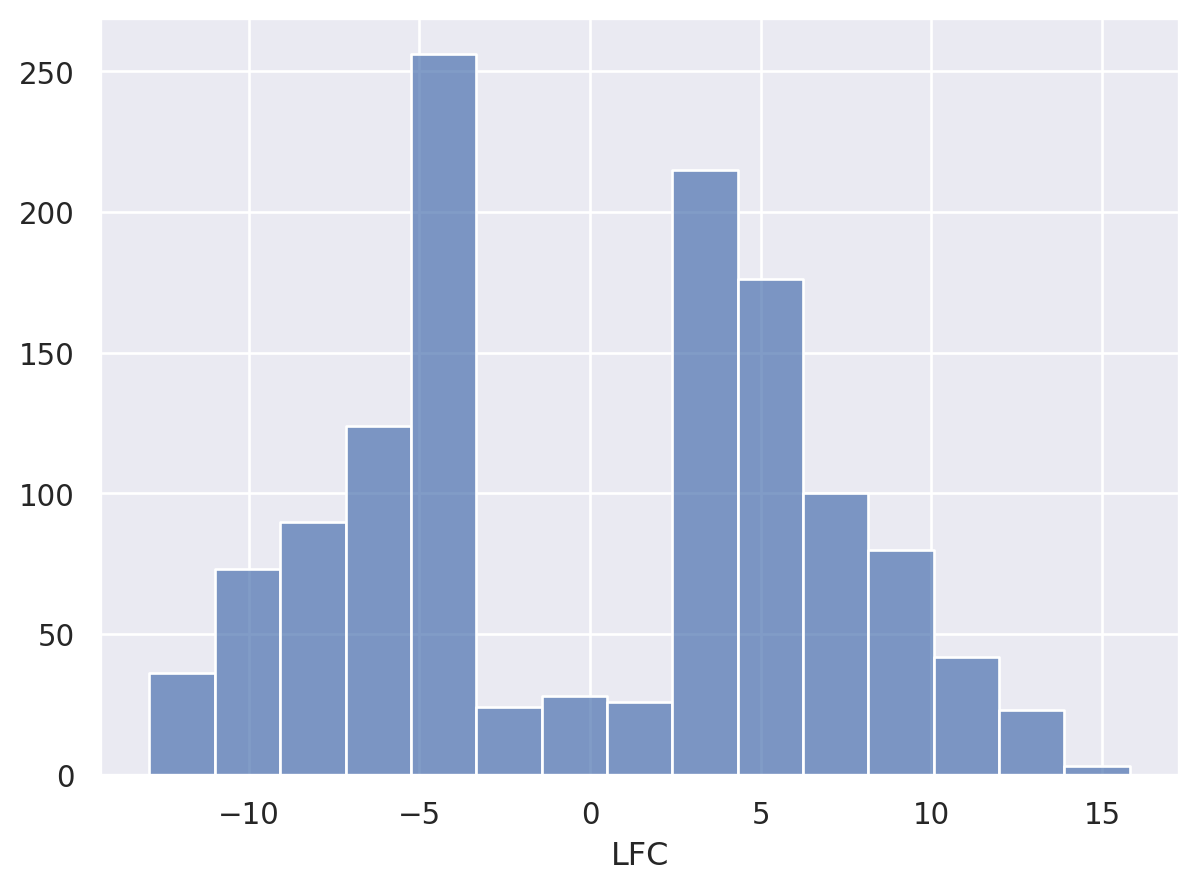

In [150]:
(
    so.Plot(pCIS_df, x="LFC")
    .add(so.Bars(), so.Hist())
)

/project/cs-myers/MathewF/software/miniconda3/envs/netcis/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


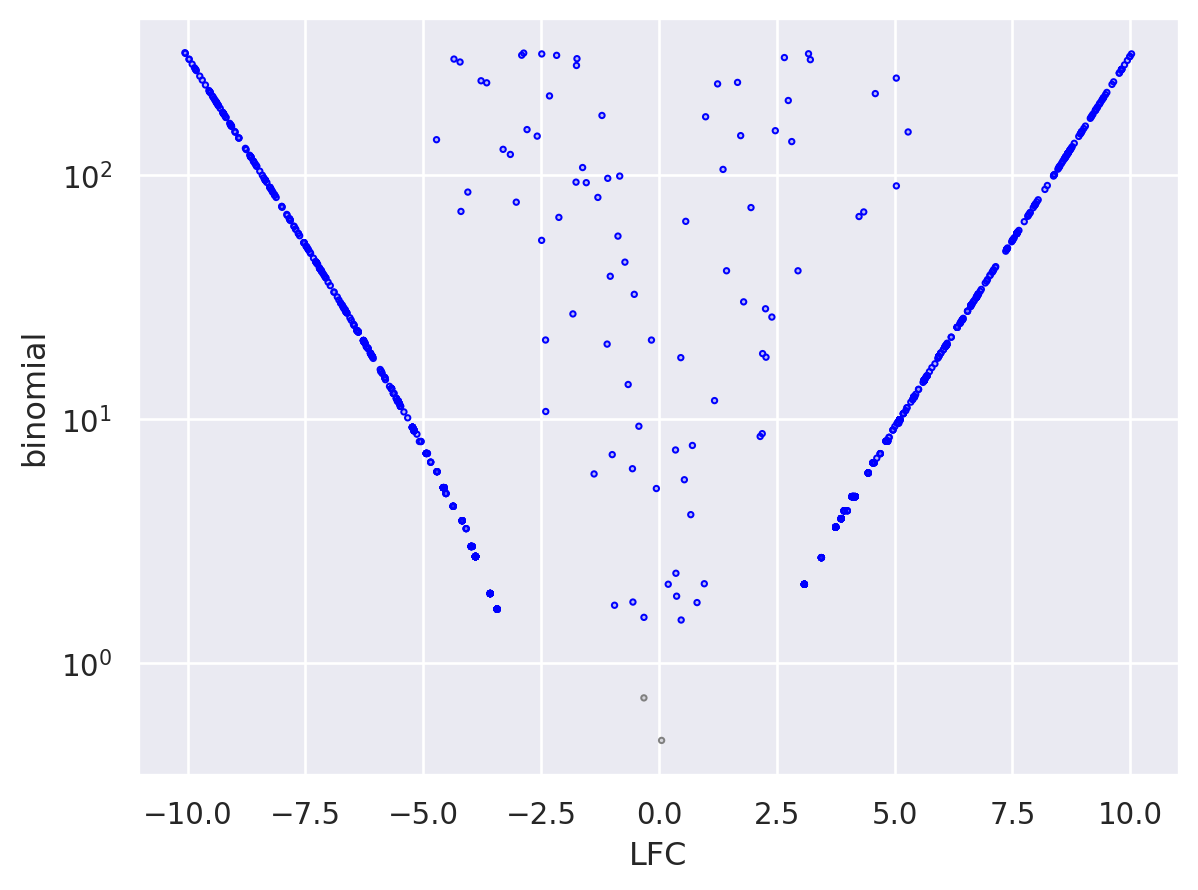

In [151]:
volcano_plot(pCIS_df, "LFC", "binomial", 0.05)

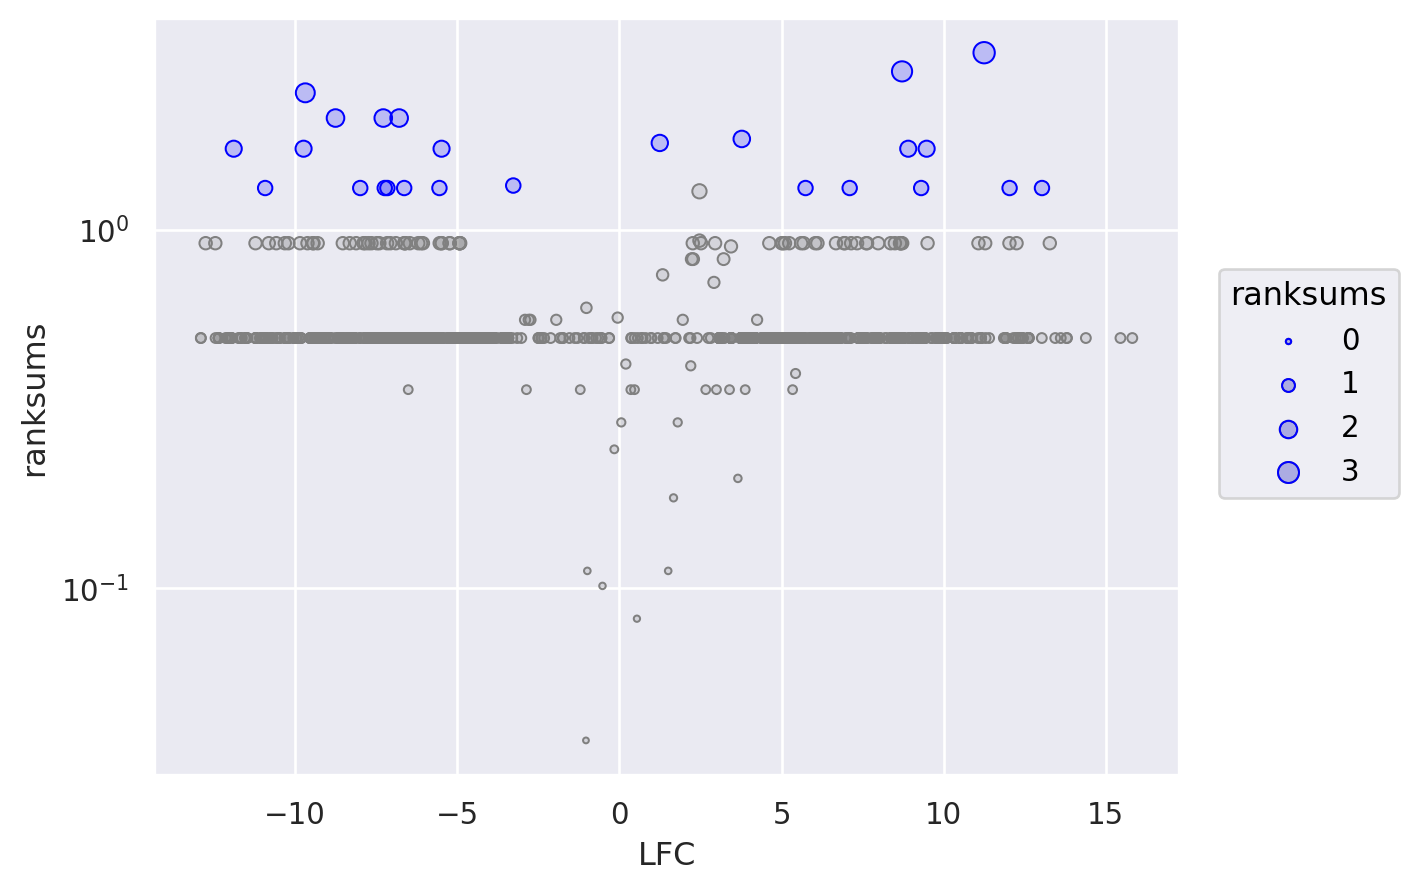

In [152]:
volcano_plot(pCIS_df, "LFC", "ranksums", 0.05)

In [167]:
# print(pCIS_df.iloc[pCIS_df["ranksums"].idxmin()])
# pCIS_df.iloc[pCIS_df["ranksums"].idxmin()]["genes"]

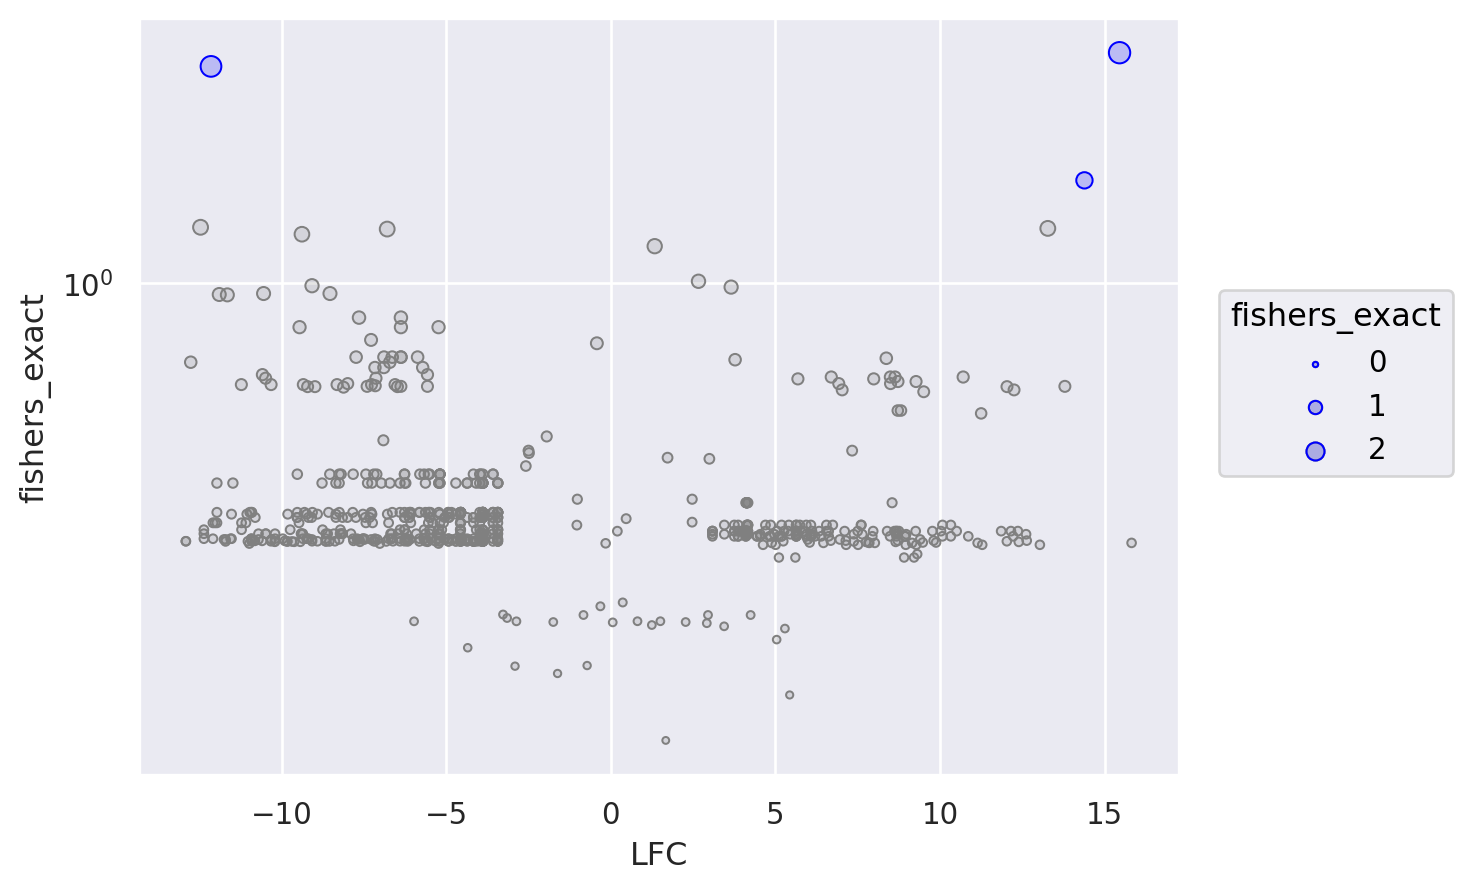

In [154]:
volcano_plot(pCIS_df, "LFC", "fishers_exact", 0.05)

In [166]:
# (pCIS_df.iloc[pCIS_df["fishers_exact"].idxmin()])

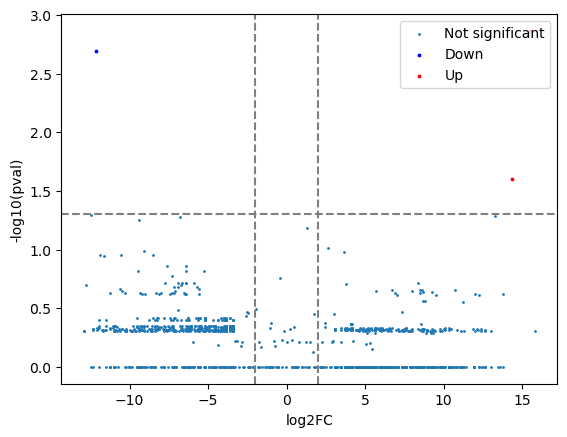

In [172]:
# https://hemtools.readthedocs.io/en/latest/content/Bioinformatics_Core_Competencies/Volcanoplot.html
df = pCIS_df.copy(deep=True)
pval = "fishers_exact"
pval_thresh = 0.05


plt.scatter(x=df["LFC"], y=df[pval].apply(lambda x:-np.log10(x)), s=1, label="Not significant")

# highlight down- or up- regulated genes
down = df[ (df['LFC'] <= -2) & (df[pval] <= pval_thresh) ]
up = df[ (df['LFC'] >= 2) & (df[pval] <= pval_thresh) ]

plt.scatter(x=down['LFC'], y=down[pval].apply(lambda x: -np.log10(x)), s=3, label="Down", color="blue")
plt.scatter(x=up['LFC'], y=up[pval].apply(lambda x: -np.log10(x)), s=3, label="Up", color="red")

# texts_up=[]
# for i,r in up.iterrows():
#     texts_up.append(plt.text(x=r['LFC'], y=-np.log10(r[pval]), s=r["genes"]))
# # adjust_text(texts,arrowprops=dict(arrowstyle="-", color='black', lw=0.5))

# texts_down=[]
# for i,r in down.iterrows():
#     texts_down.append(plt.text(x=r['LFC'], y=-np.log10(r[pval]), s=r["genes"]))
# # adjust_text(texts,arrowprops=dict(arrowstyle="-", color='black', lw=0.5))

plt.xlabel("log2FC")
plt.ylabel("-log10(pval)")
plt.axvline(-2, color="grey", linestyle="--")
plt.axvline(2, color="grey", linestyle="--")
plt.axhline(-np.log10(pval_thresh), color="grey", linestyle="--")
plt.legend()
plt.show()

# IS QC plots

In [160]:
# https://transit.readthedocs.io/en/latest/transit_quality_control.html#figure-1-read-count-distribution
# https://github.com/mad-lab/transit/blob/master/src/pytransit/qcDisplay.py
IS_df

,pos,case_count,case_index,control_count,control_index,target_binom_pval,target_binom_sig,LFC,case,control,chrom
0,19216366,16.498928,3.0,0.000000,NaN,1.525879e-05,True,4.129195,CAR,NoCAR,chr19
1,27733092,16.498928,4.0,0.000000,NaN,1.525879e-05,True,4.129195,CAR,NoCAR,chr19
2,42568654,1088.929220,5.0,0.000000,NaN,0.000000e+00,True,10.090019,CAR,NoCAR,chr19
3,33152662,16.894746,6.0,0.000000,NaN,1.525879e-05,True,4.161464,CAR,NoCAR,chr19
4,50849702,16.894746,7.0,0.000000,NaN,1.525879e-05,True,4.161464,CAR,NoCAR,chr19
...,...,...,...,...,...,...,...,...,...,...,...
1775,24017866,24.906600,21.0,2272.727273,37.0,0.000000e+00,True,-6.455596,CAR,NoCAR,chr2
1776,71622204,49.813200,23.0,28.019638,10.0,1.685309e-02,True,0.808174,CAR,NoCAR,chr2
1777,73554511,1032.366071,45.0,1886.792453,45.0,6.250018e-57,True,-0.869349,CAR,NoCAR,chr2
1778,171916456,105.820106,48.0,76.045627,38.0,3.130178e-02,True,0.471398,CAR,NoCAR,chr2


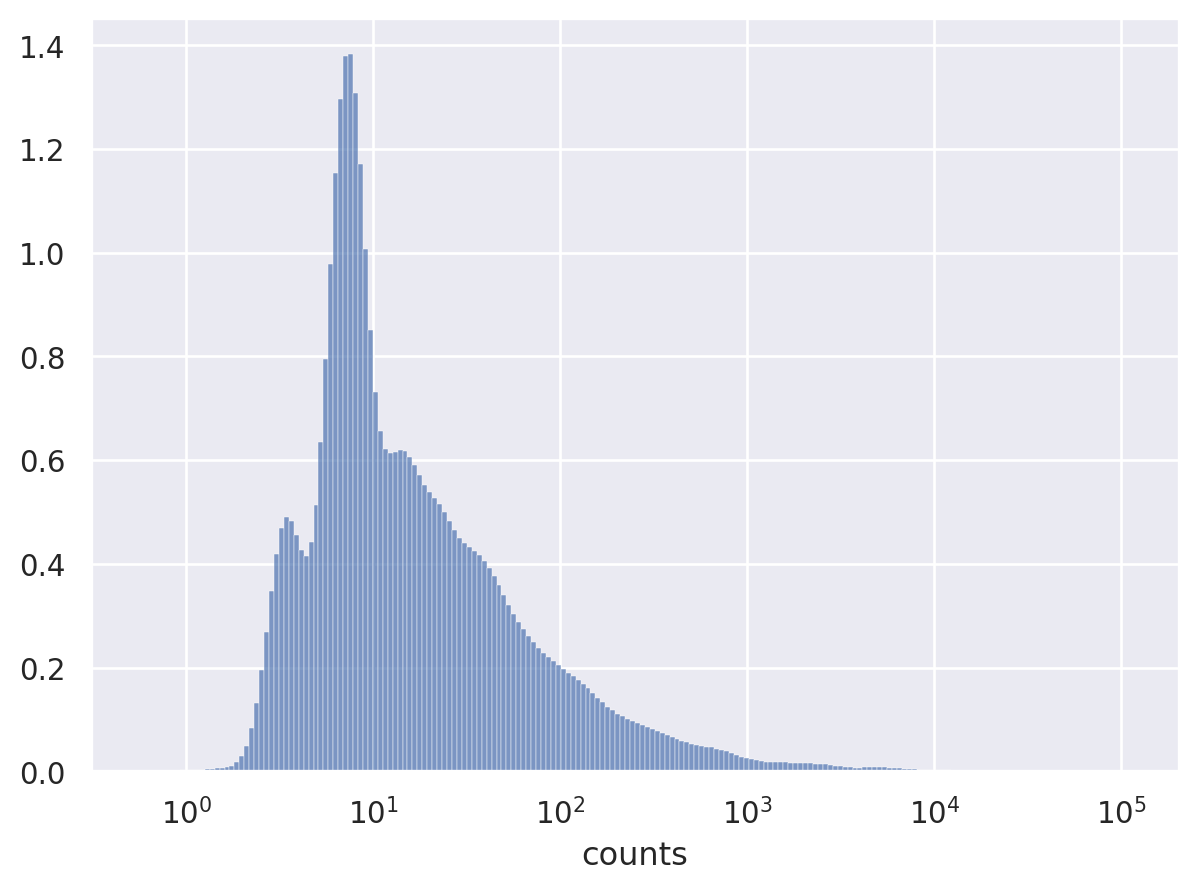

In [64]:
# Read count distribution with and without zeros
all_counts = pd.concat( (IS_df["case_count"], IS_df["control_count"]) ).to_frame("counts")
counts_NZ = all_counts[all_counts["counts"] != 0]
(
    so.Plot(counts_NZ, x="counts")
    .add(so.Bars(), so.KDE())
    .scale(x="log")
)

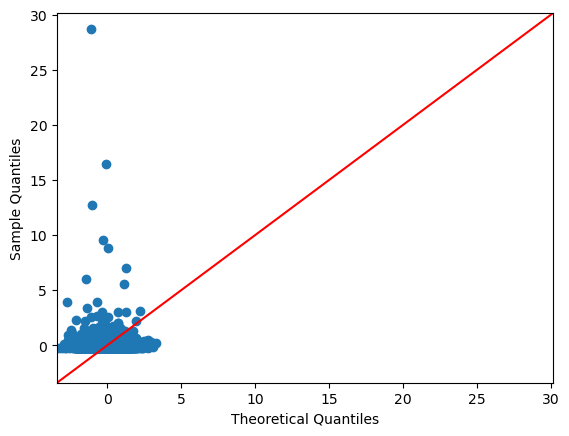

In [162]:
# QQ plot of read counts vs geometric distribution
sm.qqplot(counts_NZ, stats.norm, fit=True, line="45")
plt.show()

<Figure size 640x480 with 0 Axes>

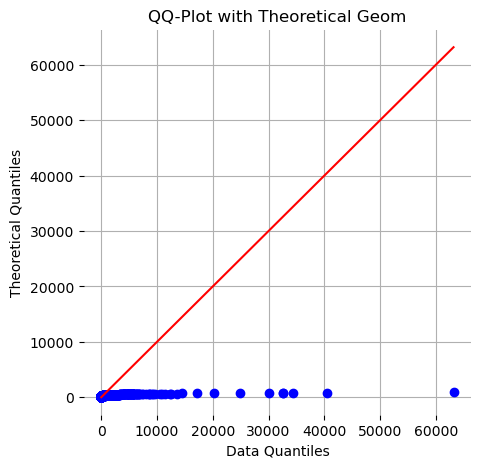

In [70]:
# copied from https://github.com/mad-lab/transit/blob/master/src/pytransit/qcDisplay.py#L259
def transit_volcano_plot(truncnzreads):
    plt.clf()
    fig = plt.figure(facecolor='white', figsize=(5, 5), dpi=100)
    ax = fig.add_subplot(111, frame_on=False)
    ((qtheoretical, qdata), (slope, intercept, r)) = stats.probplot(truncnzreads, dist="geom", sparams=(1.0/np.mean(truncnzreads),))
    ax.plot(qdata, qtheoretical, "ob")

    maxval = max(np.max(qtheoretical), np.max(qdata))
    ax.plot((0, maxval), (0, maxval), ls="-", c="r")

    plt.xlabel("Data Quantiles")
    plt.ylabel("Theoretical Quantiles")
    plt.title('QQ-Plot with Theoretical Geom')
    plt.grid(True)
    plt.show()

# TODO: correction of reads from transit?
transit_volcano_plot(counts_NZ["counts"])

24578


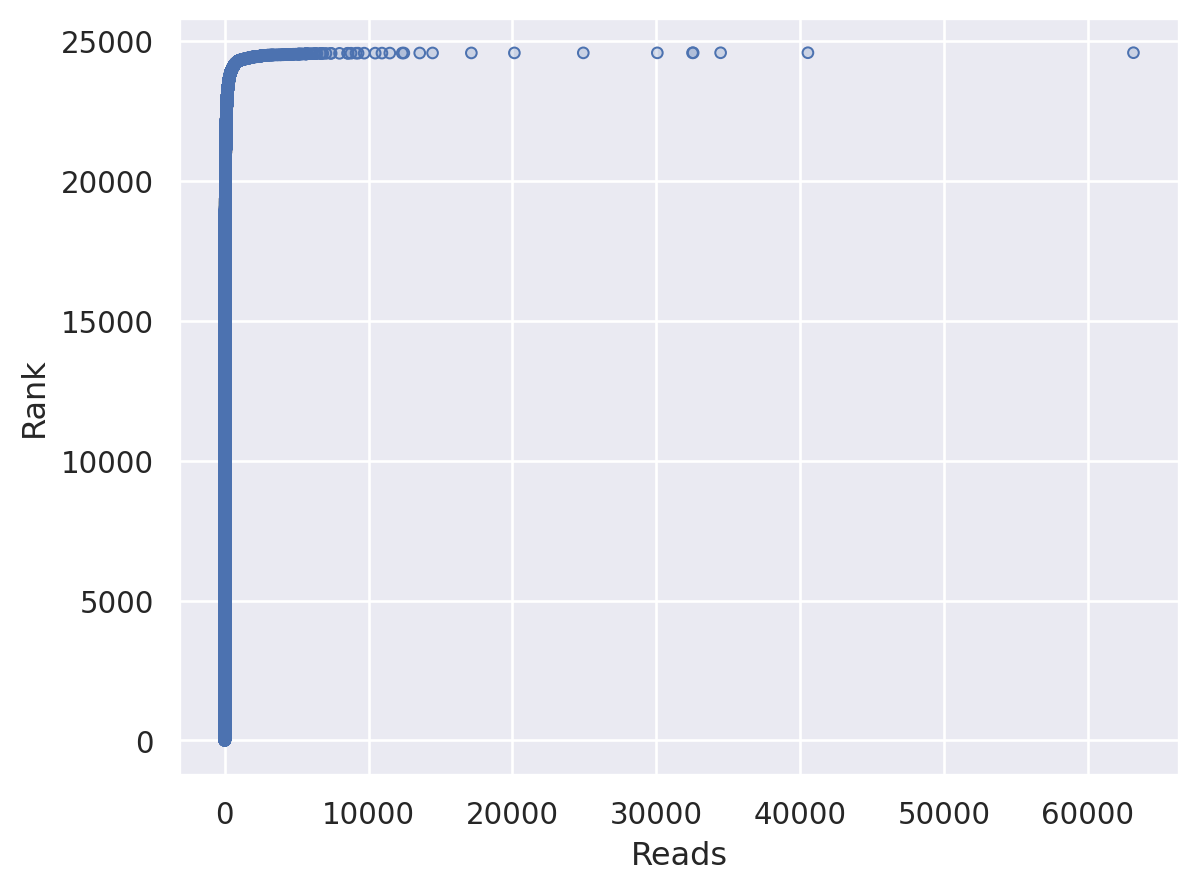

In [68]:
# Ranked plot of read counts
print(len(counts_NZ))

q1 = counts_NZ.quantile(0.25).to_numpy()[0]
q3 = counts_NZ.quantile(0.75).to_numpy()[0]
iqr = q3 - q1
outliers = counts_NZ[ (counts_NZ["counts"] < (q1 - (1.5 * iqr))) | (counts_NZ["counts"] > (q3 + (1.5 * iqr))) ]


sorted_NZ_no_outliers = counts_NZ["counts"].sort_values().to_numpy()[:-len(outliers)]
sorted_NZ_counts = counts_NZ["counts"].sort_values().to_numpy()

data = sorted_NZ_counts
rank = [x for x in range(len(data))]
(
    so.Plot(x=data, y=rank)
    .add(so.Dots())
    .label(x="Reads", y="Rank")
)

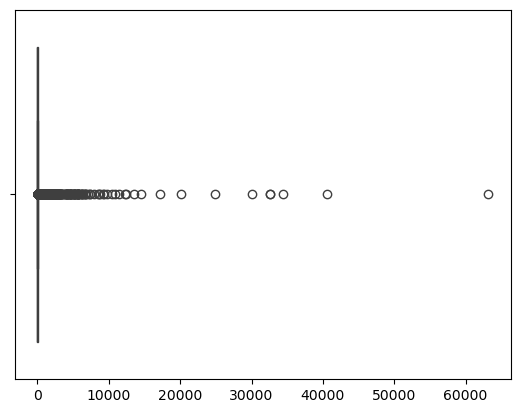

In [69]:
sns.boxplot(x=data, log_scale=False)
plt.show()